# Time Series Forecasting
## Using Machine Learning to Forecast Energy Consumption

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

## Types of Time Series Data

![](https://miro.medium.com/max/1400/1*V_RKPeIxCB9CS_2SsLyKXw.jpeg)

reference: https://engineering.99x.io/time-series-forecasting-in-machine-learning-3972f7a7a467

In [2]:
df = pd.read_csv('PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

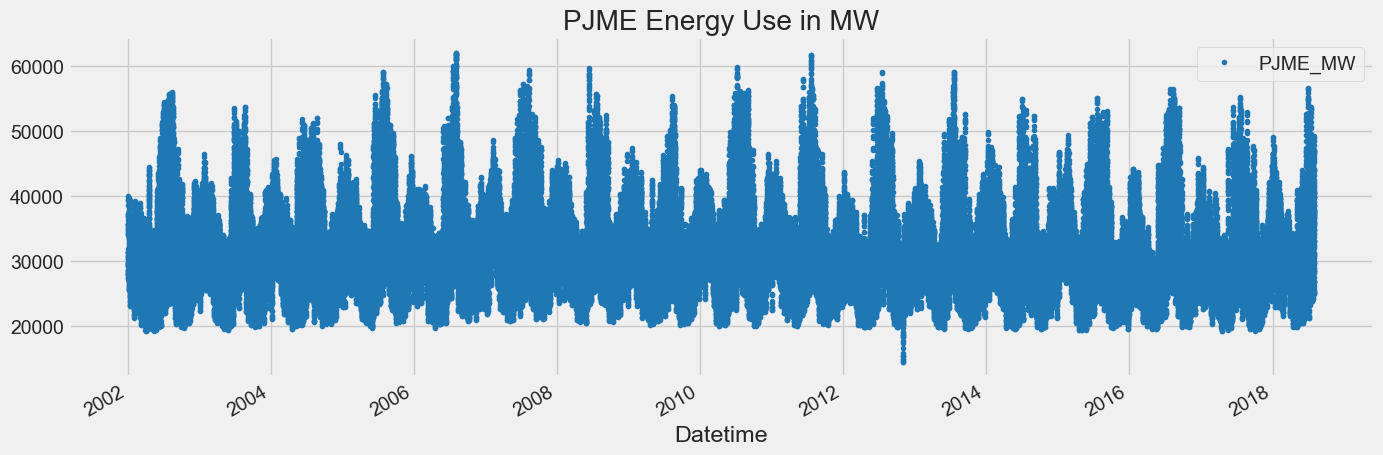

In [3]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

# Train / Test Split

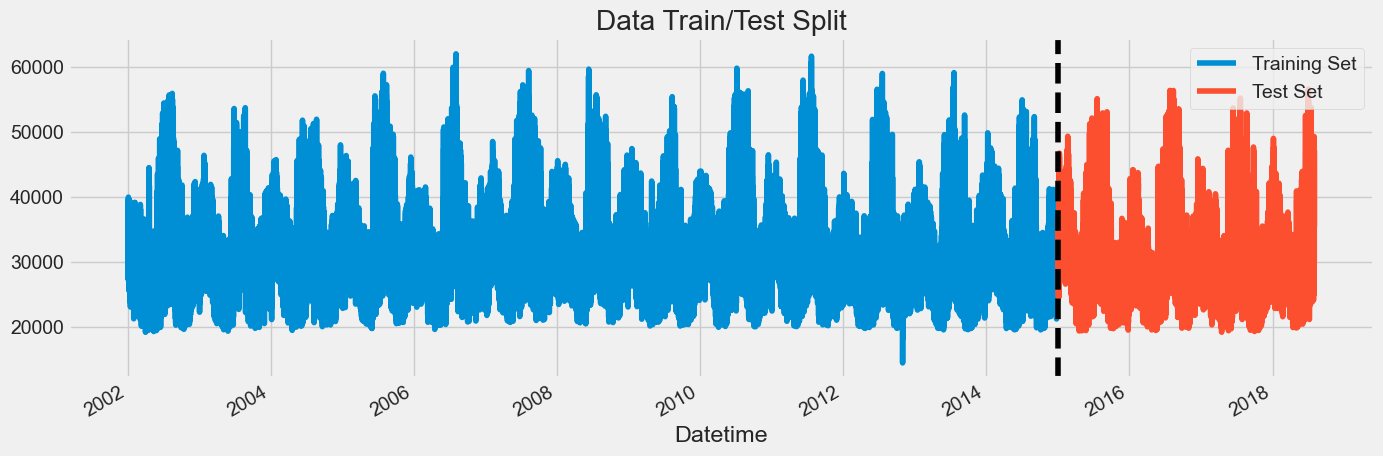

In [4]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

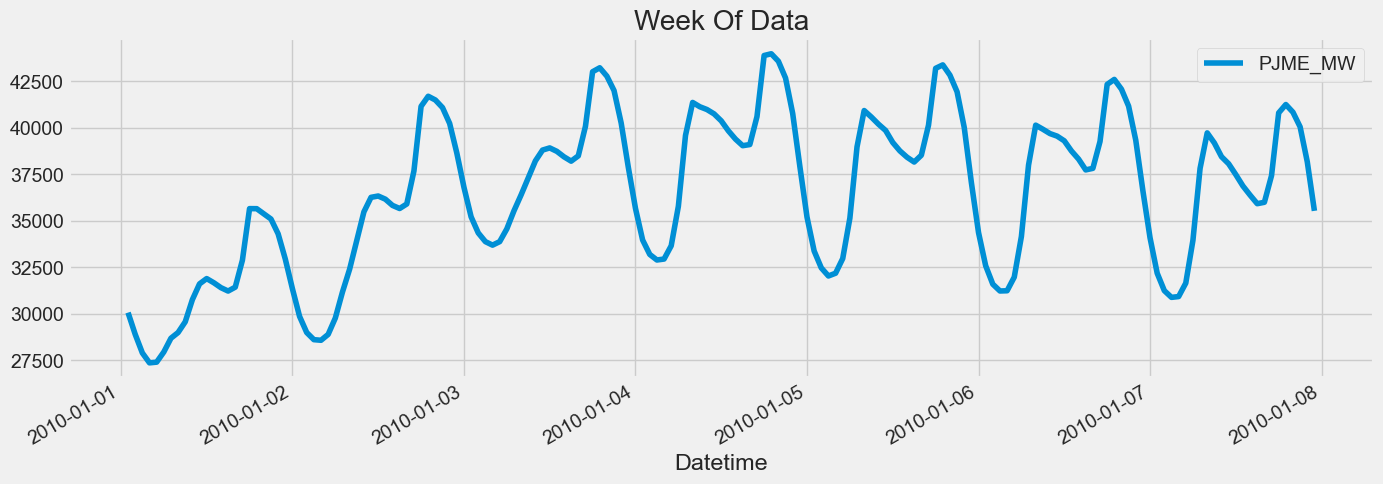

In [5]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

# Feature Creation

In [16]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)
df

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction
Datetime,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,NaN
...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,42689.429688
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,42547.425781
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,40844.238281


# Visualize our Feature / Target Relationship

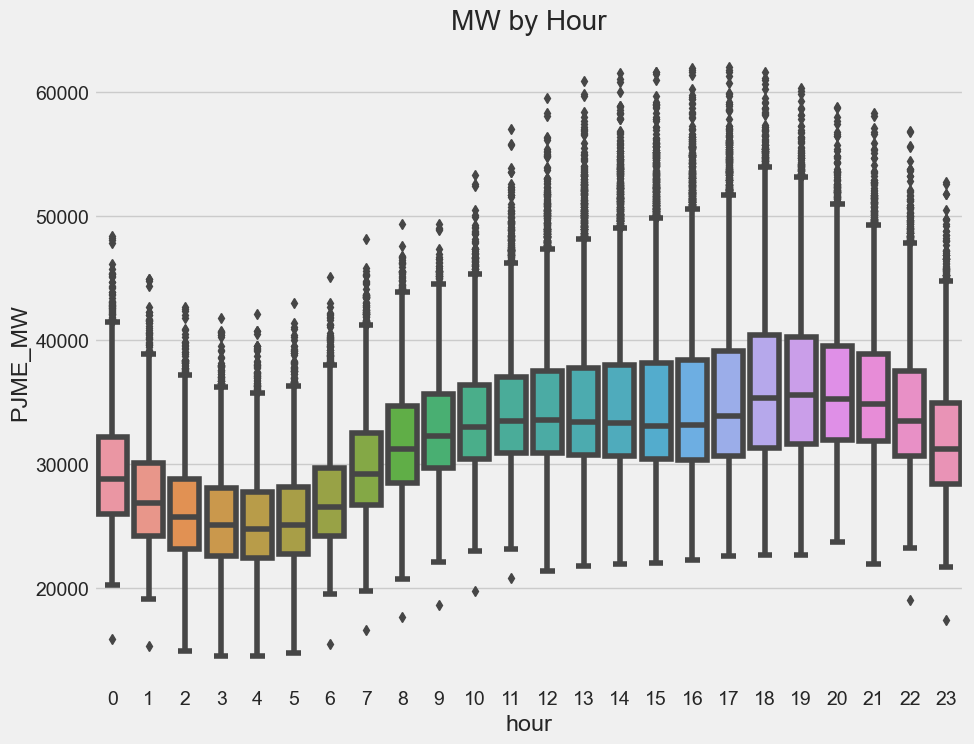

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

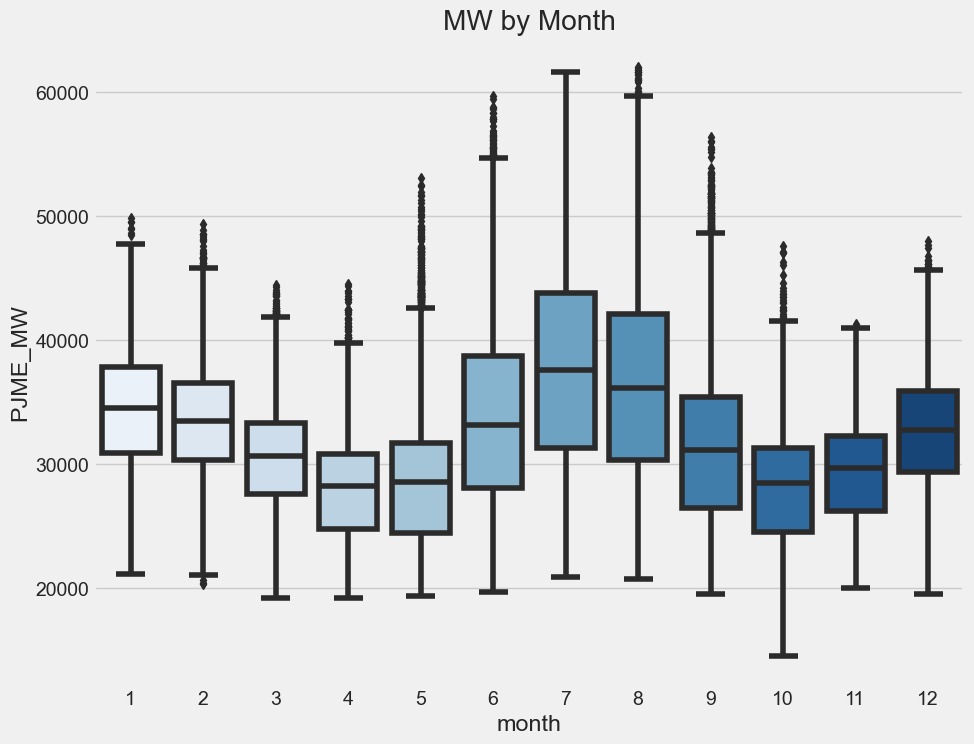

In [8]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

# Create Model

In [9]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [10]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100) # eval_set

[08:40:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32605.13860	validation_1-rmse:31657.15907
[100]	validation_0-rmse:12581.21569	validation_1-rmse:11743.75114
[200]	validation_0-rmse:5835.12466	validation_1-rmse:5365.67709
[300]	validation_0-rmse:3915.75557	validation_1-rmse:4020.67023
[400]	validation_0-rmse:3443.16468	validation_1-rmse:3853.40423
[500]	validation_0-rmse:3285.33804	validation_1-rmse:3805.30176
[600]	validation_0-rmse:3201.92936	validation_1-rmse:3772.44933
[700]	validation_0-rmse:3148.14225	validation_1-rmse:3750.91108
[800]	validation_0-rmse:3109.24248	validation_1-rmse:3733.89713
[900]	validation_0-rmse:3079.40079	validation_1-rmse:3725.61224
[999]	validation_0-rmse:3052.73503	validation_1-rmse:3722.92257


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

n_estimators=1000: Oluşturulacak ağaç sayısı. Bu, modelin karmaşıklığını belirler. Daha fazla ağaç daha karmaşık bir model demektir.

early_stopping_rounds=50: Erken durma (early stopping), model eğitimini belirli bir sayıda iterasyon boyunca değil, performans iyileşmesi durduğunda sonlandırmayı sağlar. Burada 50 iterasyon boyunca iyileşme olmazsa eğitim duracaktır.

objective='reg:linear': XGBoost'un regresyon için kullanılacağını belirtir. Bu, modelin ortalama karesel hata (MSE) gibi bir kayıp fonksiyonunu optimize etmeye çalışacağı anlamına gelir.

max_depth=3: Her ağacın maksimum derinliğini belirler. Daha düşük değerler, modelin daha basit ve genellemesi daha iyi olmasını sağlar, ancak daha karmaşık yapıları yakalayamayabilir.

learning_rate=0.01: Öğrenme oranı, her iterasyonda modelin ne kadar öğreneceğini belirler. Düşük bir öğrenme oranı, daha güvenilir ve istikrarlı bir eğitim sağlayabilir, ancak daha uzun sürebilir.

fit: Bu yöntem, modeli eğitmek için kullanılır. Eğitim verileri X_train ve hedef değerler y_train olarak sağlanır.

eval_set: Modelin eğitim sırasında performansını izlemek için kullanılacak veri setlerini belirtir. İlk demet, eğitim verilerini ve hedefleri içerirken, ikinci demet test verilerini ve hedefleri içerir.

verbose=100: Eğitim sırasında çıktının ne kadar ayrıntılı olacağını belirtir. Burada, her 100 iterasyonda bir çıktı alınacaktır.

# Feature Importance

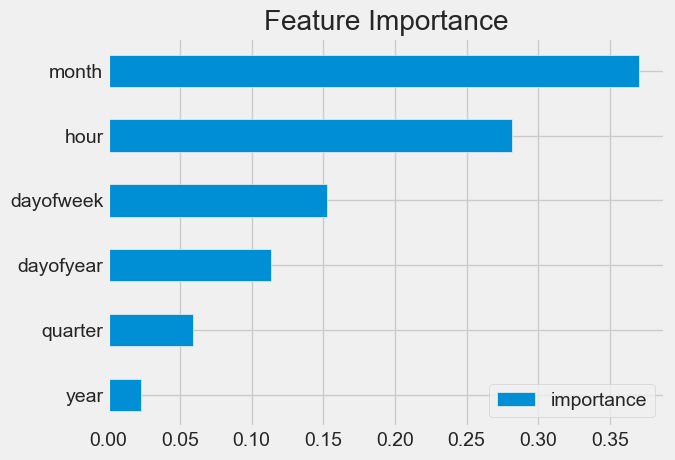

,importance
dayofyear,0.113569
hour,0.281722
dayofweek,0.152942
quarter,0.058814
month,0.369963
year,0.022991


In [17]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()
fi

# Forecast on Test

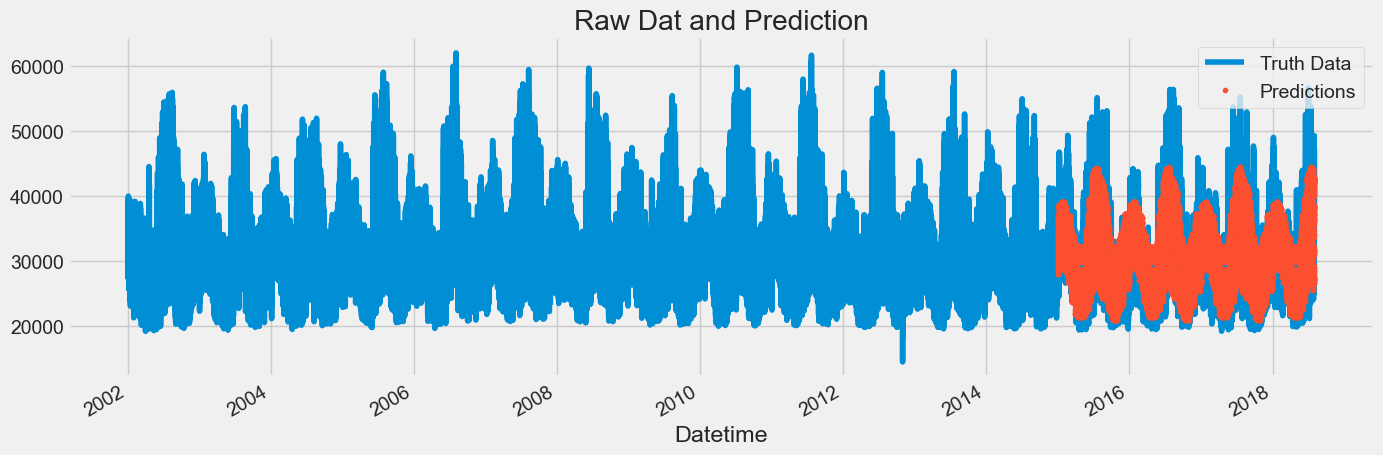

In [12]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

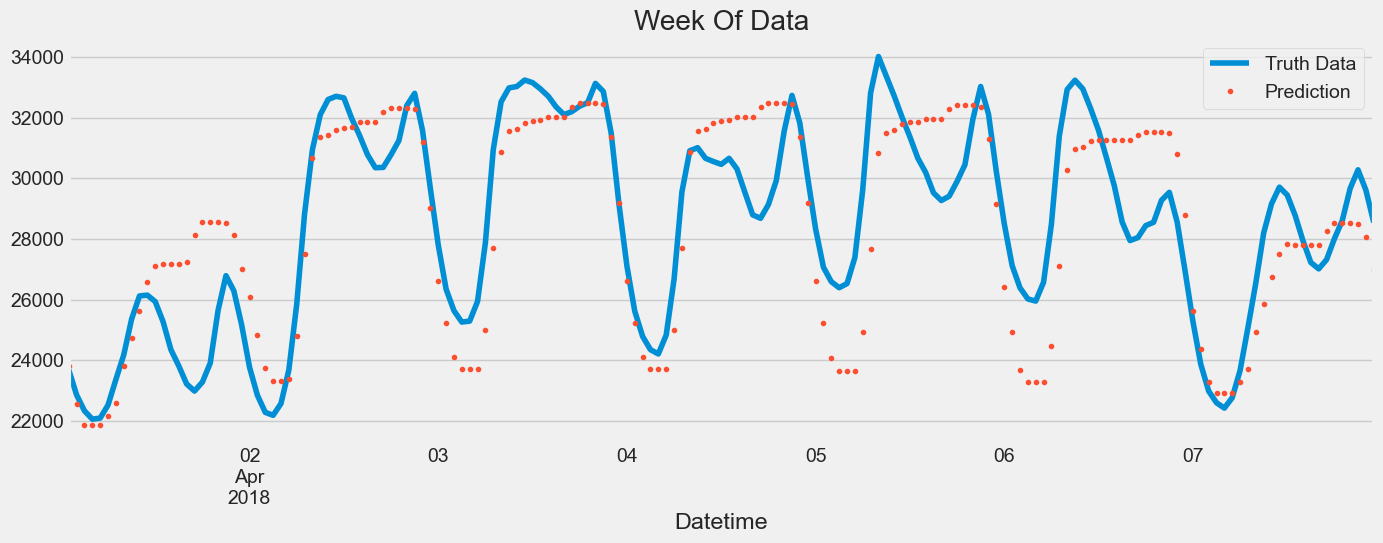

In [13]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

# Score (RMSE)

In [14]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3721.75


# Calculate Error
- Look at the worst and best predicted days

In [15]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    12839.597087
2016-08-14    12780.209961
2016-09-10    11356.302979
2015-02-20    10965.982259
2016-09-09    10864.954834
2018-01-06    10506.845622
2016-08-12    10124.051595
2015-02-21     9881.803711
2015-02-16     9781.552246
2018-01-07     9739.144206
Name: error, dtype: float64

In [19]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=True).head(10)

date
2017-10-24    349.390462
2015-10-28    397.410807
2016-10-27    528.968913
2015-05-06    529.528971
2017-10-15    535.292318
2018-05-16    585.349935
2016-10-08    625.825439
2015-10-03    653.130941
2016-09-16    656.402995
2015-11-06    674.912109
Name: error, dtype: float64